# Anomaly Detection in Financial Transactions (Fraud Detection)
### Statistical Modeling + Anomaly Detection (GLM Diagnostics + Isolation Forest)

## What is this project about?

Fraud detection in financial transactions is an anomaly detection problem where fraudulent events are **rare** and costly. The goal is to build methods that can help identify suspicious transactions.


## Project objective

Detect fraudulent transactions using:
1. **Supervised statistical modeling**: a Binomial GLM (logit link) that outputs fraud probabilities.
2. **Statistical anomaly detection**: residual and influence diagnostics from the GLM to flag unusual transactions.
3. **Unsupervised anomaly detection**: Isolation Forest trained without labels.
4. **Evaluation**: precision, recall, F1, confusion matrix, ROC-AUC, PR-AUC.

In this setting, accuracy is misleading because the dataset is highly imbalanced. We focus on precision/recall trade-offs and ranking quality.


## How to run

**Expected files in the same folder as this notebook:**
- `creditcard.csv` (Kaggle Credit Card Fraud Detection dataset)
- `AnomalyDetection_utils.py` (helper functions for preprocessing, modeling, and plots)

**Python dependencies (typical):**
- numpy, pandas, matplotlib
- scikit-learn, imbalanced-learn
- statsmodels

Run the notebook top-to-bottom (Kernel → Restart & Run All) for a clean reproducible run.


## Dataset description

We use the Kaggle **Credit Card Fraud Detection** dataset (European cardholders, September 2013).

### What does the dataset contain?
- **Rows:** individual credit-card transactions
- **Target label:** `Class`
  - `0` = legitimate transaction
  - `1` = fraud

### Features
- `V1` to `V28`: anonymized PCA-transformed features  
  These are transformations of original transaction attributes (unknown for privacy reasons).
- `Time`: seconds elapsed between each transaction and the first transaction in the dataset
- `Amount`: transaction amount

### Why fraud detection is challenging
Fraud cases are extremely rare (around 0.17%). A naïve classifier could label everything as non-fraud and achieve >99% accuracy, but it would catch **zero fraud**. Therefore, we evaluate using:
- **Recall** (how many frauds we catch)
- **Precision** (how many flagged transactions are truly fraud)
- **ROC-AUC / PR-AUC** (ranking quality, especially PR-AUC for rare events)


In [1]:
from AnomalyDetection_utils import load_data, basic_eda, class_distribution
import os

# Dataset file should be present in the same directory as this notebook.
DATA_PATH = os.path.join(os.getcwd(), "creditcard.csv")

df = load_data(DATA_PATH)
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Step 1 — Basic integrity checks and class imbalance

Before modeling, we verify:
- shape (number of rows/columns),
- missing values,
- basic summary statistics,
- how imbalanced the fraud vs legitimate classes are.

Premise:
- If the dataset has missing values or inconsistent structure, models may fail or behave unpredictably.

Inference:
- After confirming data integrity, we quantify the imbalance to motivate evaluation choices and modeling strategy.


=== Basic EDA ===
Shape: (284807, 31)

Total missing values: 0

Summary statistics:
                 Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5

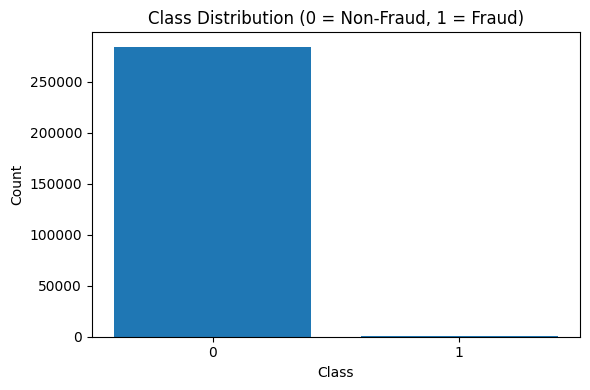

Class
0    284315
1       492
Name: count, dtype: int64

In [2]:
basic_eda(df)
class_distribution(df)


## Step 2 — Preprocessing pipeline (time-aware split, scaling, SMOTE)

### Why we do a time-aware split
Transactions occur over time. If we randomly shuffle and split, we risk leakage: the training set could contain “future-like” patterns that appear in the test set.

Premise:
- A realistic deployment trains on past transactions and predicts on future ones.

Inference:
- Sorting by `Time` and splitting chronologically creates a more realistic evaluation.

### Why scaling is needed
Even though PCA features are roughly standardized, `Amount` and `Time` can have very different scales.
Scaling helps models converge and makes features comparable.

### Why SMOTE is used (only for supervised training)
GLM is trained in a supervised way. With extreme imbalance, the model may under-learn fraud patterns.
SMOTE synthesizes minority class examples to help supervised training.

Important premise:
- **SMOTE is applied only on training data** to avoid contaminating evaluation.
- The test set remains imbalanced to reflect real-world prevalence.

We also keep **scaled training data before SMOTE**, because unsupervised anomaly detection models should not be trained on synthetic points.


In [3]:
from AnomalyDetection_utils import prepare_data

(
    X_train_res,
    X_test_scaled,
    y_train_res,
    y_test,
    scaler,
    X_train_scaled,
    y_train,
) = prepare_data(df, scale_method="standard")

print("Training (after SMOTE):", X_train_res.shape, y_train_res.shape)
print("Training (scaled, pre-SMOTE):", X_train_scaled.shape, y_train.shape)
print("Test:", X_test_scaled.shape, y_test.shape)



=== After SMOTE (Training Set) ===
Class
0    227428
1    227428
Name: count, dtype: int64
Training (after SMOTE): (454856, 30) (454856,)
Training (scaled, pre-SMOTE): (227845, 30) (227845,)
Test: (56962, 30) (56962,)


## Step 3 — Supervised baseline: Binomial GLM (logistic regression via statsmodels)

### What is a GLM here?
A Binomial GLM with a logit link is equivalent to logistic regression:
- It models the probability of fraud as a function of the features.
- Output: a probability score in [0, 1] for each transaction.

### Why use statsmodels instead of sklearn?
Premise:
- The project requires statistical modeling + diagnostics.

Inference:
- statsmodels provides residuals and influence diagnostics (deviance residuals, leverage, Cook’s distance),
  which we later use for anomaly detection in a statistically grounded way.

Note:
- Since V1–V28 are PCA components, coefficients do not have a direct business interpretation.
- We use GLM mainly for prediction ranking + diagnostics.


In [4]:
from AnomalyDetection_utils import fit_glm_statsmodels

glm_result = fit_glm_statsmodels(X_train_res, y_train_res)

# Full summary is large but provides model diagnostics; keep it for transparency.
print(glm_result.summary().tables[0])
print(glm_result.summary().tables[1])



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               454856
Model:                            GLM   Df Residuals:                   454825
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -59291.
Date:                Tue, 16 Dec 2025   Deviance:                   1.1858e+05
Time:                        01:18:07   Pearson chi2:                 1.43e+17
No. Iterations:                    15   Pseudo R-squ. (CS):             0.6755
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6581      0.016   -232.362      0.0

## Step 4 — GLM residual and influence diagnostics (what do they mean?)

After fitting the GLM, we compute diagnostics that help identify observations that are unusual relative to the model.

### Diagnostics used
1. **Standardized deviance residuals**
   - Measures how poorly the model explains an observation.
   - Large magnitude indicates the point is surprising given the model’s predicted probability.

2. **Leverage**
   - Measures whether the transaction has an unusual combination of feature values.
   - High leverage points can disproportionately influence the fit.

3. **Cook’s distance**
   - Combines residual size + leverage to estimate how influential a point is on fitted parameters.
   - High values indicate influential observations.

Premise:
- Fraudulent transactions may behave differently from typical transactions.
Inference:
- Large residuals or high influence can be used to flag anomalies, even without choosing a probability threshold.


In [5]:
from AnomalyDetection_utils import compute_glm_diagnostics
import matplotlib.pyplot as plt
import numpy as np

diagnostics_train = compute_glm_diagnostics(glm_result, X_train_res, y_train_res)

std_dev_train = diagnostics_train["std_deviance"]
leverage_train = diagnostics_train["leverage"]
cooks_train = diagnostics_train["cooks_distance"]

print("Std deviance residuals (train) sample:")
print(std_dev_train.head())


Std deviance residuals (train) sample:
0   -1.737814
1   -0.772866
2   -1.304446
3   -0.700891
4   -0.483470
dtype: float64


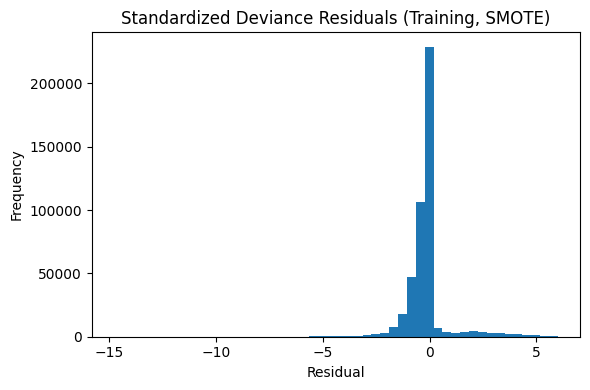

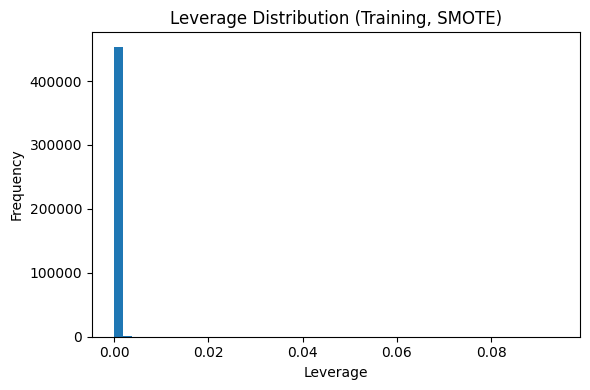

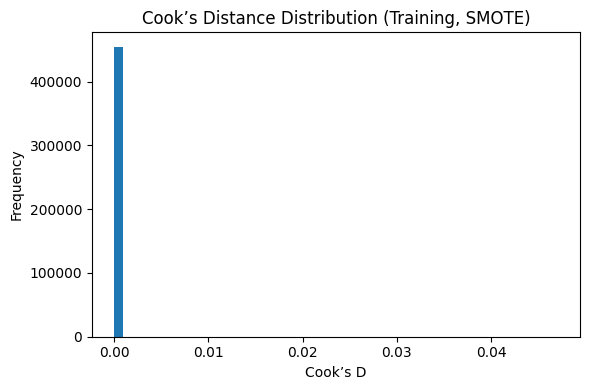

In [6]:
plt.figure(figsize=(6,4))
plt.hist(std_dev_train, bins=50)
plt.title("Standardized Deviance Residuals (Training, SMOTE)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(leverage_train, bins=50)
plt.title("Leverage Distribution (Training, SMOTE)")
plt.xlabel("Leverage")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(cooks_train, bins=50)
plt.title("Cook’s Distance Distribution (Training, SMOTE)")
plt.xlabel("Cook’s D")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Step 5 — Diagnostics-based anomaly detection (evaluated on the imbalanced test set)

We now convert diagnostics into anomaly flags using a transparent rule:

Flag a transaction as anomalous if:
- |standardized deviance residual| > 3  
  (extreme model misfit)
OR
- leverage above the 99th percentile  
  (unusual feature pattern)
OR
- Cook’s distance above the 99th percentile  
  (high influence)

Premise:
- These thresholds identify extreme observations relative to the fitted GLM.

Important:
- Although diagnostics can be computed on the training set, evaluation should be done on the **original imbalanced test set**
  to reflect realistic fraud prevalence.


In [7]:
from AnomalyDetection_utils import flag_anomalies_from_diagnostics, evaluate_anomaly_flags

diagnostics_test = compute_glm_diagnostics(glm_result, X_test_scaled, y_test)

flags_test, thresholds = flag_anomalies_from_diagnostics(
    diagnostics_test["std_deviance"],
    diagnostics_test["leverage"],
    diagnostics_test["cooks_distance"],
)

print("Thresholds used:", thresholds)

test_diag_results = evaluate_anomaly_flags(y_test, flags_test)

print("\n=== GLM Diagnostics Anomaly Detection (Test Set) ===")
for k, v in test_diag_results.items():
    print(f"{k}: {v}")


Thresholds used: {'std_threshold': 3.0, 'leverage_cutoff': 0.004948031797153167, 'cooks_cutoff': 0.00017670794453271359}

=== GLM Diagnostics Anomaly Detection (Test Set) ===
TP: 13
FP: 2163
FN: 62
TN: 54724
precision: 0.0059742647058823525
recall: 0.17333333333333334


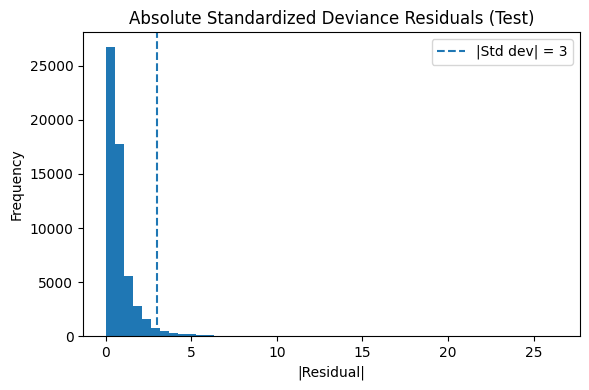

In [8]:
plt.figure(figsize=(6,4))
plt.hist(np.abs(diagnostics_test["std_deviance"]), bins=50)
plt.axvline(3, linestyle="--", label="|Std dev| = 3")
plt.legend()
plt.title("Absolute Standardized Deviance Residuals (Test)")
plt.xlabel("|Residual|")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## Step 6 — Supervised evaluation of GLM probabilities on test data

The GLM outputs probabilities. To evaluate the model as a classifier, we pick a threshold (default 0.5) and compute:

- Confusion matrix
- Precision / recall / F1-score
- ROC curve + ROC-AUC (ranking quality)
- Precision-Recall curve + PR-AUC (more informative in rare-event problems)

Premise:
- Fraud detection systems often prioritize recall (catch fraud), but operational constraints require controlling false alarms.
Inference:
- We evaluate both ranking quality (AUCs) and classification behavior at thresholds.


=== Supervised GLM Evaluation (Test Set, threshold=0.5) ===
Precision: 0.0680
Recall:    0.8800
F1 Score:  0.1263
ROC AUC:   0.9859
PR AUC:    0.7771


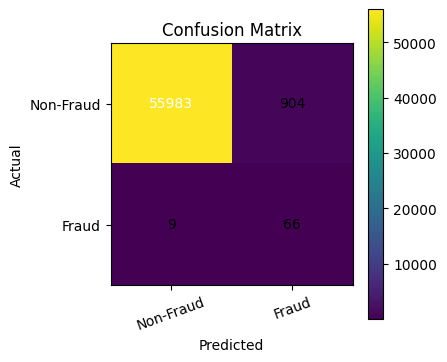

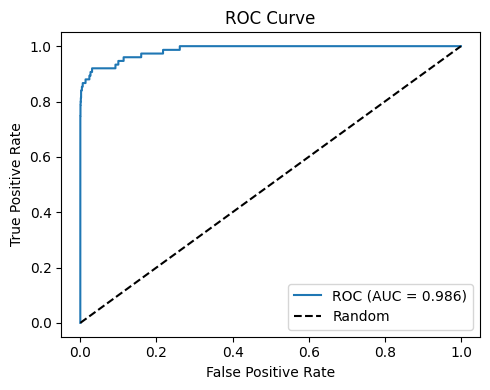

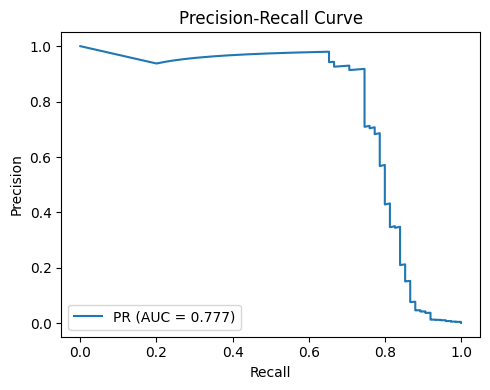

In [9]:
from AnomalyDetection_utils import (
    glm_predict_proba,
    evaluate_supervised,
    plot_confusion_matrix,
    plot_roc_curve_from_metrics,
    plot_pr_curve_from_metrics,
)

y_proba = glm_predict_proba(glm_result, X_test_scaled)
metrics = evaluate_supervised(y_test, y_proba, threshold=0.5)

print("=== Supervised GLM Evaluation (Test Set, threshold=0.5) ===")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1']:.4f}")
print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
print(f"PR AUC:    {metrics['pr_auc']:.4f}")

plot_confusion_matrix(metrics["confusion_matrix"])
plot_roc_curve_from_metrics(metrics)
plot_pr_curve_from_metrics(metrics)


### Step 6.1 — Threshold selection with a recall constraint

In fraud detection, missing fraud can be more costly than false alarms.  
Here we choose a threshold that achieves at least a target recall (e.g., 0.90) and then examine what precision and F1-score result.

Premise:
- Adjusting the threshold shifts the precision–recall trade-off.

Inference:
- A recall-constrained threshold helps illustrate operational decision making.


=== Threshold Selected (recall ≥ 0.90) ===
Selected threshold: 0.3580
Precision: 0.0427
Recall:    0.9067
F1 Score:  0.0816


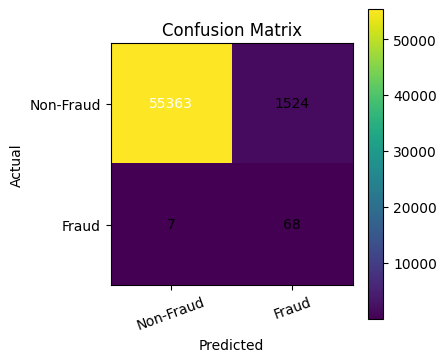

In [10]:
import numpy as np

target_recall = 0.90
threshold_grid = np.linspace(0.001, 0.5, 500)

best_threshold = None
best_metrics = None
best_f1 = -1.0

for t in threshold_grid:
    m = evaluate_supervised(y_test, y_proba, threshold=float(t))
    if m["recall"] >= target_recall and m["f1"] > best_f1:
        best_f1 = m["f1"]
        best_threshold = float(t)
        best_metrics = m

if best_threshold is None:
    print(f"No threshold in [0.001, 0.5] achieved recall ≥ {target_recall:.2f}.")
else:
    print(f"=== Threshold Selected (recall ≥ {target_recall:.2f}) ===")
    print(f"Selected threshold: {best_threshold:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall:    {best_metrics['recall']:.4f}")
    print(f"F1 Score:  {best_metrics['f1']:.4f}")

    plot_confusion_matrix(best_metrics["confusion_matrix"])


## Step 7 — Unsupervised anomaly detection with Isolation Forest

### What is Isolation Forest?
Isolation Forest is an unsupervised anomaly detection algorithm that isolates points by randomly partitioning the feature space.  
Anomalies tend to be isolated faster, so they receive higher anomaly scores.

Premise:
- In some environments, labels are unavailable or delayed.
Inference:
- Unsupervised anomaly detection can still provide a way to flag suspicious transactions.

Important:
- We train Isolation Forest on the **training data before SMOTE** (real distribution, no synthetic points).
- We evaluate on the imbalanced test set to compare behavior against true fraud labels.


=== Isolation Forest Evaluation (Test Set) ===
Precision: 0.0257
Recall:    0.8267
F1 Score:  0.0499
ROC AUC:   0.9499
PR AUC:    0.0491


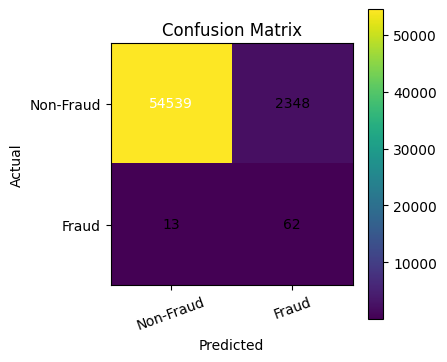

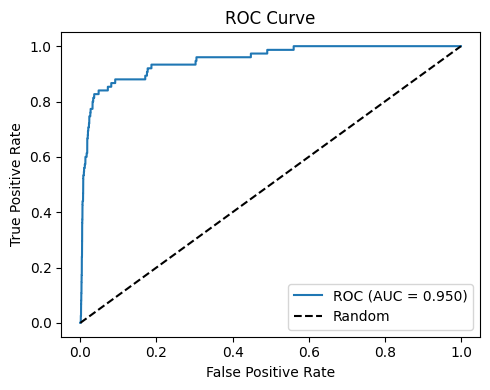

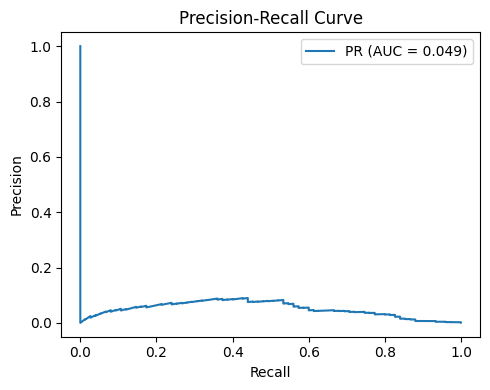

In [11]:
from AnomalyDetection_utils import fit_isolation_forest, evaluate_isolation_forest
from AnomalyDetection_utils import plot_confusion_matrix, plot_roc_curve_from_metrics, plot_pr_curve_from_metrics


iso_model = fit_isolation_forest(X_train_scaled, contamination="auto", random_state=42)
iso_metrics = evaluate_isolation_forest(iso_model, X_test_scaled, y_test)

print("=== Isolation Forest Evaluation (Test Set) ===")
print(f"Precision: {iso_metrics['precision']:.4f}")
print(f"Recall:    {iso_metrics['recall']:.4f}")
print(f"F1 Score:  {iso_metrics['f1']:.4f}")
print(f"ROC AUC:   {iso_metrics['roc_auc']:.4f}")
print(f"PR AUC:    {iso_metrics['pr_auc']:.4f}")

plot_confusion_matrix(iso_metrics["confusion_matrix"])
plot_roc_curve_from_metrics(iso_metrics)
plot_pr_curve_from_metrics(iso_metrics)


## Step 8 — Statistical test: are fraud transactions flagged more often?

To include an explicit statistical test, we apply a **two-proportion z-test**:

- Group 1: fraud transactions (`Class=1`)
- Group 2: legitimate transactions (`Class=0`)

Null hypothesis:
- Fraud and legitimate transactions are flagged at the same rate.

Alternative hypothesis (one-sided):
- Fraud transactions are flagged at a higher rate.

We apply this test to:
- diagnostics-based flags
- Isolation Forest flags

Inference:
- A small p-value supports that anomaly flags are statistically associated with fraud labels (not random).


In [12]:
from AnomalyDetection_utils import two_proportion_ztest_flag_rate

diag_test = two_proportion_ztest_flag_rate(y_test, flags_test, alternative="larger")
if_test = two_proportion_ztest_flag_rate(y_test, iso_metrics["anomaly_flags"], alternative="larger")

print("=== Two-proportion z-test (GLM diagnostics flags) ===")
print(diag_test)

print("\n=== Two-proportion z-test (Isolation Forest flags) ===")
print(if_test)


=== Two-proportion z-test (GLM diagnostics flags) ===
{'z': 6.1093822170744385, 'p_value': 5.000876835924281e-10, 'fraud_flag_rate': 0.17333333333333334, 'legit_flag_rate': 0.03802274684901647, 'n_fraud': 75.0, 'n_legit': 56887.0}

=== Two-proportion z-test (Isolation Forest flags) ===
{'z': 33.76776347927241, 'p_value': 2.9330060070094905e-250, 'fraud_flag_rate': 0.8266666666666667, 'legit_flag_rate': 0.0412748079526078, 'n_fraud': 75.0, 'n_legit': 56887.0}


## 9. Summary and takeaways

This notebook compared three complementary perspectives:

1. **GLM diagnostics (rule-based anomaly flags):**  
   Provides explainable signals (residuals, leverage, influence) and a transparent statistical way to flag unusual transactions.

2. **Supervised GLM probabilities:**  
   Gives strong ranking performance (ROC-AUC / PR-AUC). The threshold determines how aggressive the system is (recall vs precision).

3. **Isolation Forest (unsupervised):**  
   Works without labels and can detect outliers, but may generate more false positives in highly imbalanced fraud settings.

Overall, this project demonstrates why fraud detection is fundamentally a trade-off between catching rare events and minimizing false alerts.
